In [2]:
import sys, os
script_directory = os.path.abspath('.')
print(script_directory)
sys.path.append(script_directory)

e:\Programming\Python\project_GeoNeuro\project_moires\spatial_cognition_moire\Analysis


In [3]:
# ref 这波是改工作目录，默认为ipynb文件所在目录
os.chdir(os.path.abspath('..'))
print(os.getcwd())

e:\Programming\Python\project_GeoNeuro\project_moires\spatial_cognition_moire


In [4]:
sys.path

['d:\\Application\\Conda\\envs\\geoneuro\\python39.zip',
 'd:\\Application\\Conda\\envs\\geoneuro\\DLLs',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib',
 'd:\\Application\\Conda\\envs\\geoneuro',
 '',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\win32',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\win32\\lib',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\Pythonwin',
 'e:\\Programming\\Python\\project_GeoNeuro\\project_moires\\spatial_cognition_moire\\Analysis']

In [5]:
import shap
# ref 和Python文件不一样，jupyter会自动检索工作目录的模块，如果存在则自动添加到sys.path中，不需要手动添加
import packFuncForShap as pack4shap
sys.path

['d:\\Application\\Conda\\envs\\geoneuro\\python39.zip',
 'd:\\Application\\Conda\\envs\\geoneuro\\DLLs',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib',
 'd:\\Application\\Conda\\envs\\geoneuro',
 '',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\win32',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\win32\\lib',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\Pythonwin',
 'e:\\Programming\\Python\\project_GeoNeuro\\project_moires\\spatial_cognition_moire\\Analysis',
 'e:\\Programming\\Python\\project_GeoNeuro\\project_moires\\spatial_cognition_moire']

In [6]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
from itertools import repeat, chain
from functools import partial

In [7]:
import importlib
importlib.reload(pack4shap)
import pickle

In [7]:
evolution_model_path = r'./model/36384703(default)/complete_model'
params_list = os.listdir(evolution_model_path)
date_list = [int(params.rstrip('.pickle')) for params in params_list]
date_list = date_list[::7]

In [9]:
shap_calculates = dict()

for date in date_list:
    print('Iteration date: {date}'.format(date=date))
    path = evolution_model_path + '/{date}.pickle'.format(date=date)

    model = pack4shap.loadModel(path=path)
    modelPredWrapper = partial(pack4shap.modelPredict, model=model, attribute_type='reward')

    dataset = pack4shap.backgroundData(date = date)
    dataset_uni = np.unique(dataset, axis=0)
    print('Data with {k} rows'.format(k=dataset_uni.shape[0]))

    built_bench = np.zeros(model.s_dim).reshape(1, -1)
    locat_bench = np.mean(dataset[:, model.s_dim:], axis=0).reshape(1, -1)
    zero_bench = np.zeros(dataset.shape[1]).reshape(1, -1)
    home_bench = np.hstack((built_bench, locat_bench))

    explainer = shap.PermutationExplainer(modelPredWrapper, home_bench)
    shap_values = explainer(dataset_uni)
    print()
    shap_calculates[date] = shap_values
    with open('./product/shap_results.pickle', 'wb') as f:
        pickle.dump(shap_calculates, f)

Iteration date: 20190707


FileNotFoundError: [Errno 2] No such file or directory: './data/user_data/36384703/before_migrt.json'

In [6]:
with open('./product/shap_results.pickle', 'rb') as f:
    shap_calculates = pickle.load(f)

In [28]:
shap_values = shap_calculates[20190707]

In [8]:
varchr = 'home_distance,LU_Business,LU_City_Road,LU_Consumption,LU_Culture,LU_Industry,LU_Medical,LU_Park_&_Scenery,LU_Public,LU_Residence,LU_Science_&_Education,LU_Special,LU_Transportation,LU_Wild'
varname_BE = varchr.split(',')
varname_PE = ['PE%02d' % i for i in range(6 * len(varname_BE))]
varname = varname_BE + varname_PE
groupmap = {
    'BuiltAttr': varname[:14],
    'Location': varname[14:]
}

In [9]:
def grouped_shap(shap_vals, features, groups):
    revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))    
    
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

shap_groups = [grouped_shap(shap_vals=shap_values.values, features=varname, groups=groupmap) for shap_values in shap_calculates.values()]


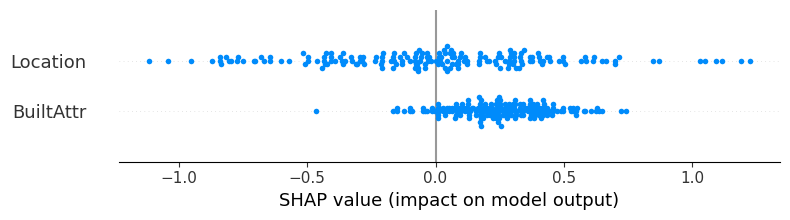

In [21]:
shap.summary_plot(shap_groups[0].values, features=shap_groups[0].columns)

In [41]:
[np.abs(shap_group.to_numpy()).mean(axis=0) for shap_group in shap_groups]

[array([0.26544334, 0.34821922]),
 array([0.22709377, 0.31956049]),
 array([0.20212909, 0.27512485]),
 array([0.18119031, 0.25772984]),
 array([0.18313264, 0.25171924]),
 array([0.13666154, 0.22788395]),
 array([0.10710524, 0.2090997 ]),
 array([0.09467388, 0.19354023]),
 array([0.08337173, 0.1752699 ]),
 array([0.07774873, 0.17746285]),
 array([0.07190034, 0.16776664]),
 array([0.06773915, 0.16148704]),
 array([0.06871705, 0.16575081]),
 array([0.06620341, 0.15976782]),
 array([0.06184063, 0.14295139]),
 array([0.05383955, 0.1348622 ]),
 array([0.0516635 , 0.12936071]),
 array([0.04993415, 0.12209753]),
 array([0.04780919, 0.11624306]),
 array([0.04646633, 0.1145877 ]),
 array([0.04656302, 0.10994515]),
 array([0.04943983, 0.11023461]),
 array([0.04761842, 0.10437344]),
 array([0.04844023, 0.10532066]),
 array([0.04700578, 0.10357835])]

In [13]:
ans = [np.abs(shap_group.to_numpy()).mean(axis=0) for shap_group in shap_groups]
shap_val = np.array(ans)

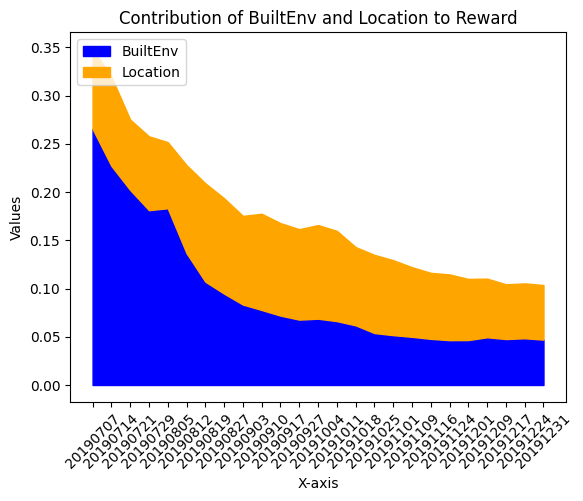

In [28]:
from matplotlib import pyplot as plt

x = np.arange(len(shap_val))
# 创建图形和轴
fig, ax = plt.subplots()

y1 = shap_val[:, 0]
y2 = shap_val[:, 1]
# 绘制堆叠区域
ax.fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
ax.fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of BuiltEnv and Location to Reward')
ax.set_xlabel('X-axis')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in date_list], rotation=45)

# 显示图表
plt.show()

In [30]:
shap_ratio = shap_val / shap_val.sum(axis=1).reshape(-1, 1)

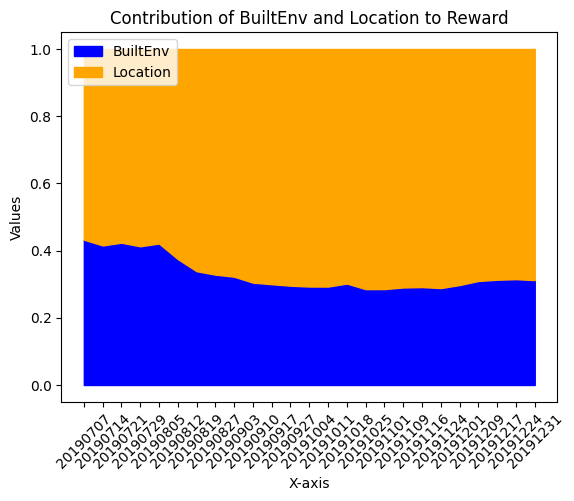

In [31]:
x = np.arange(len(shap_val))
# 创建图形和轴
fig, ax = plt.subplots()

y1 = shap_ratio[:, 0]
y2 = np.ones_like(y1)
# 绘制堆叠区域
ax.fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
ax.fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of BuiltEnv and Location to Reward')
ax.set_xlabel('X-axis')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in date_list], rotation=45)

# 显示图表
plt.show()

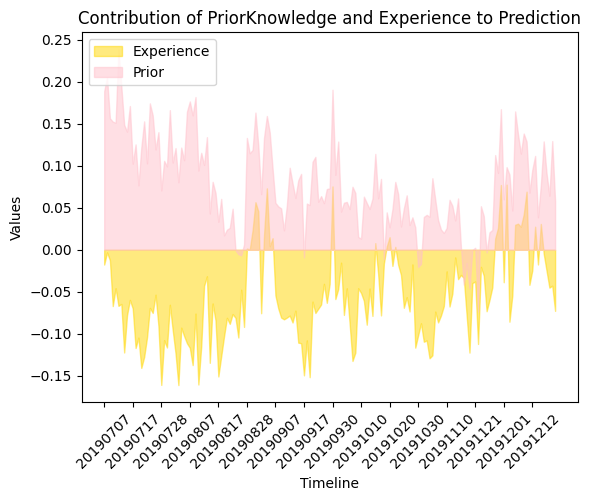

In [42]:
import pandas as pd

df_eval = pd.read_csv('./product/evolution_evaluation.csv')

x = df_eval.index
# 创建图形和轴
fig, ax = plt.subplots()

y1 = df_eval.pr_mse_contrib
y2 = df_eval.exp_mse_contrib

y1 = df_eval.pr_mse_contrib
y2 = df_eval.exp_mse_contrib

# 绘制堆叠区域
ax.fill_between(x, -y2, color='gold', alpha=0.5, label='Experience')  # 绿色区域，堆叠在蓝色区域之上
ax.fill_between(x, y1, color='pink', alpha=0.5, label='Prior')  # 蓝色区域

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of PriorKnowledge and Experience to Prediction')
ax.set_xlabel('Timeline')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x[::10])
labels = [str(d) for d in df_eval.date]
ax.set_xticklabels(labels[::10], rotation=45)

# 显示图表
plt.show()

Analysis

In [7]:
shap_path = './product/shap_personne/'
shap_list = os.listdir(shap_path)

In [8]:
with open(shap_path + shap_list[-1], 'rb') as f:
    shap_calculates = pickle.load(f)


In [9]:
shap_res = shap_calculates.copy()

In [10]:
shap_list

['shap_res_21410711.pkl',
 'shap_res_33816672.pkl',
 'shap_res_37852495.pkl',
 'shap_res_43283109.pkl',
 'shap_res_63445952.pkl',
 'shap_res_68492654.pkl',
 'shap_res_four_indivis.pkl']

In [11]:
for file in shap_list[:-1]:
    with open(shap_path + file, 'rb') as f:
        shap_one_person = pickle.load(f)
    who = int(file.rstrip('.pkl').split('_')[-1])
    for date in shap_one_person.keys():
        shap_res[(who, date)] = shap_one_person[date]

In [12]:
keyData = list(shap_res.keys())
keyDf = pd.DataFrame(keyData, columns=['who', 'date'])
whos = keyDf.who.unique()

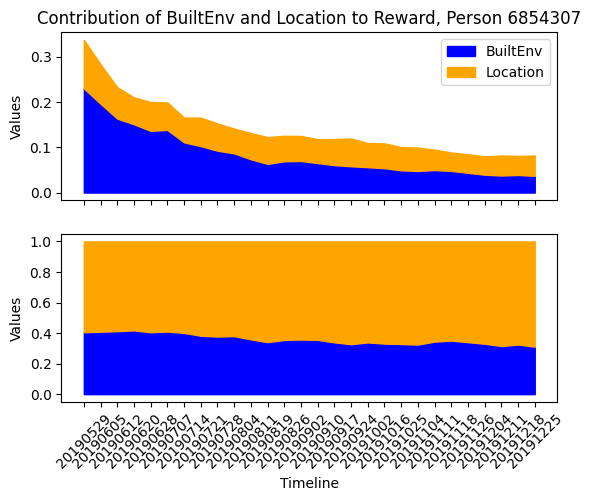

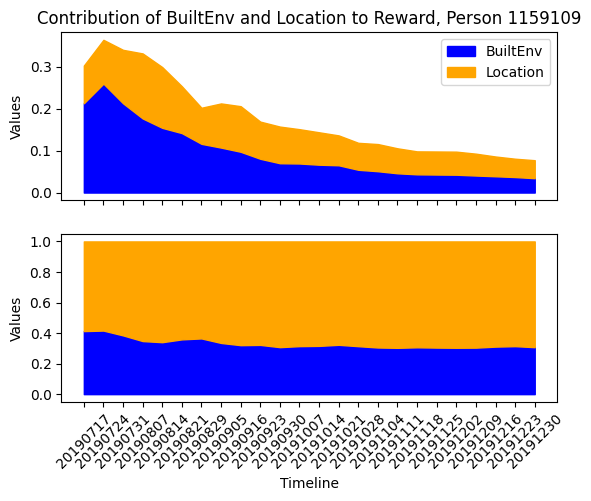

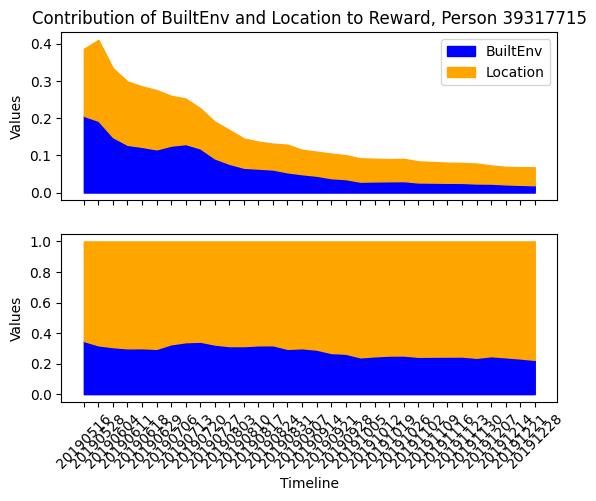

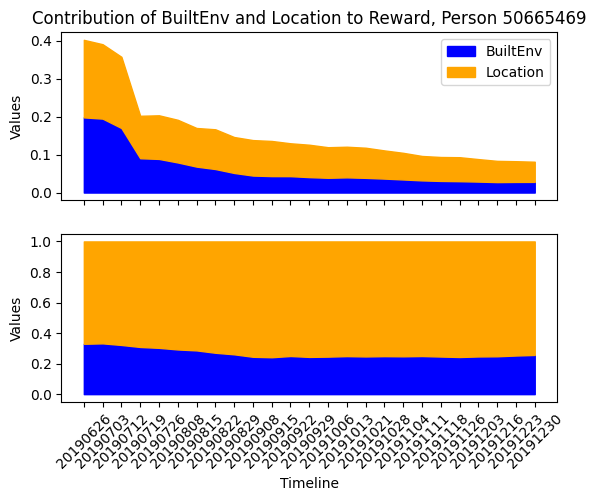

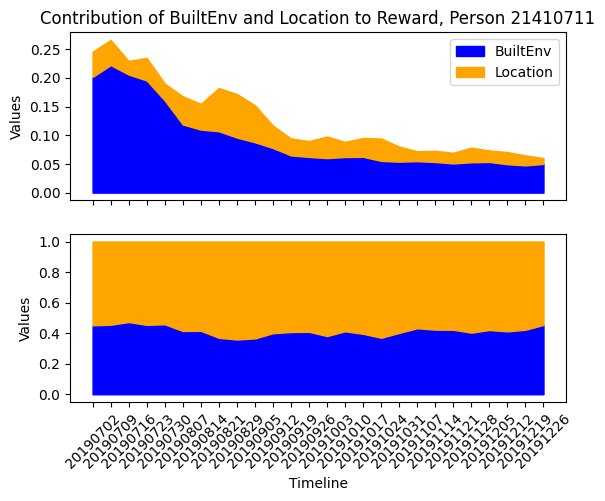

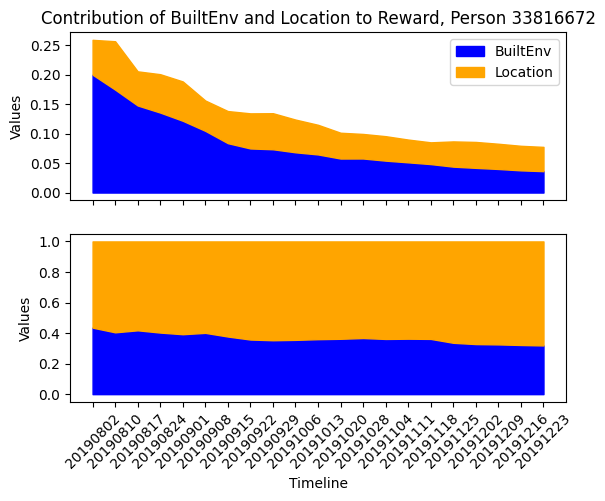

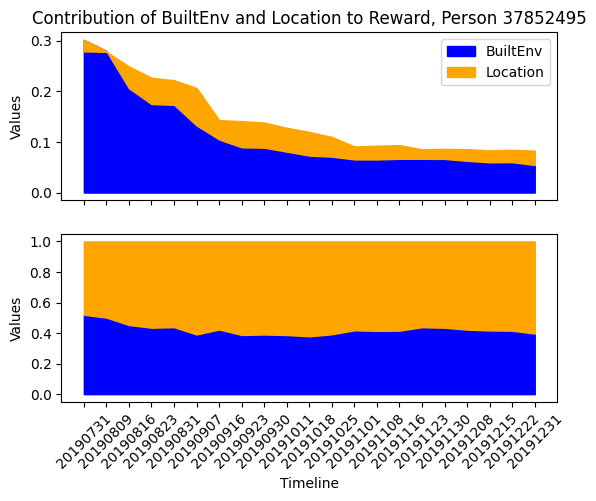

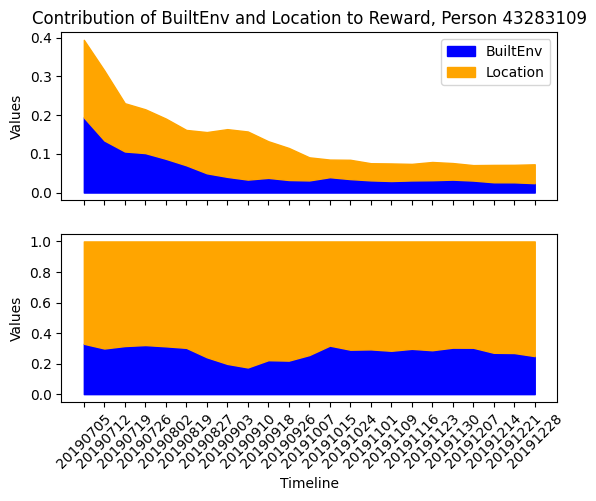

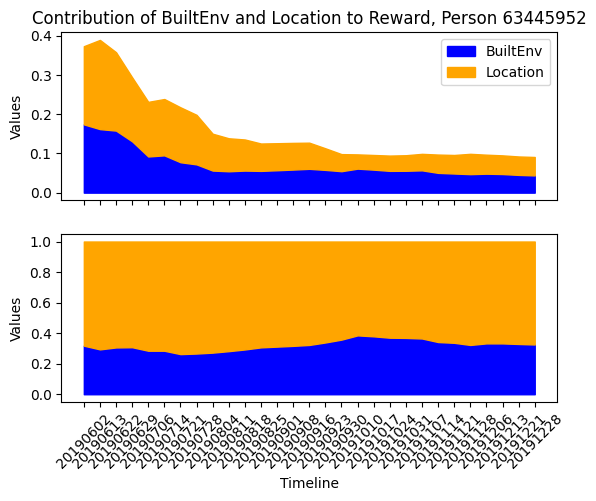

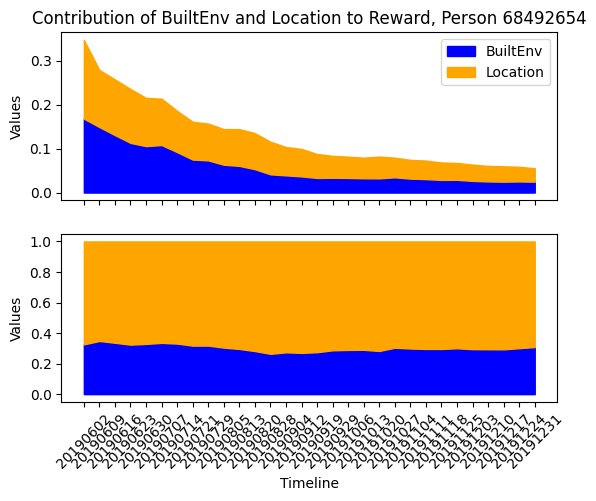

In [21]:
from matplotlib import pyplot as plt

for who in whos:
    keyWho = [(pair[0], pair[1]) for pair in keyData if pair[0] == who]
    keyWho.sort(key=lambda x: x[1])
    shap_agg = [shap_res[pair].abs().mean(axis=0) for pair in keyWho]
    
    shap_val = pd.concat(shap_agg, axis=1).T.to_numpy()
    shap_ratio = shap_val / shap_val.sum(axis=1).reshape(-1, 1)
    date_list = [pair[1] for pair in keyWho]
    
    # drawing...
    x = np.arange(len(shap_val))
    # 创建图形和轴
    fig, ax = plt.subplots(2, 1)

    y1 = shap_val[:, 0]
    y2 = shap_val[:, 1]
    # 绘制堆叠区域
    ax[0].fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
    ax[0].fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

    # 设置图例
    ax[0].legend(loc='upper right')

    # 设置图表标题和坐标轴标签
    ax[0].set_title(f'Contribution of BuiltEnv and Location to Reward, Person {who}')
    ax[0].set_xlabel(None)
    ax[0].set_ylabel('Values')

    # 将横坐标的标签设置为日期datelist
    ax[0].set_xticks(x)
    ax[0].set_xticklabels([])

    y1 = shap_ratio[:, 0]
    y2 = np.ones_like(y1)
    # 绘制堆叠区域
    ax[1].fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
    ax[1].fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

    # 设置图例

    # 设置图表标题和坐标轴标签
    ax[1].set_title(None)
    ax[1].set_xlabel('Timeline')
    ax[1].set_ylabel('Values')

    # 将横坐标的标签设置为日期datelist
    ax[1].set_xticks(x)
    ax[1].set_xticklabels([str(d) for d in date_list], rotation=45)

    plt.savefig('./product/person_{who:08d}_shap.png'.format(who=who))
    # 显示图表
    plt.show()

In [28]:
interp_path = './product/interpretEvo/'
interp_list = os.listdir(interp_path)

interp_res = dict()
for file in interp_list:
    with open(interp_path + file, 'rb') as f:
        interp_one_person = pickle.load(f)
    key = interp_one_person.keys()
    key = list(key)[0]
    interp_res[key] = interp_one_person[key]

In [32]:
interp_one_person[68492654]

,date,pr_contrib,exp_contrib
0,20190602,0.344455,0.019746
1,20190603,0.210646,0.133176
2,20190604,0.269047,0.066533
3,20190605,0.476513,0.029900
4,20190606,0.422389,0.059429
...,...,...,...
189,20191217,5.807609,0.026670
190,20191218,4.995370,0.093325
191,20191219,4.987492,0.085606
192,20191220,4.695856,0.087544


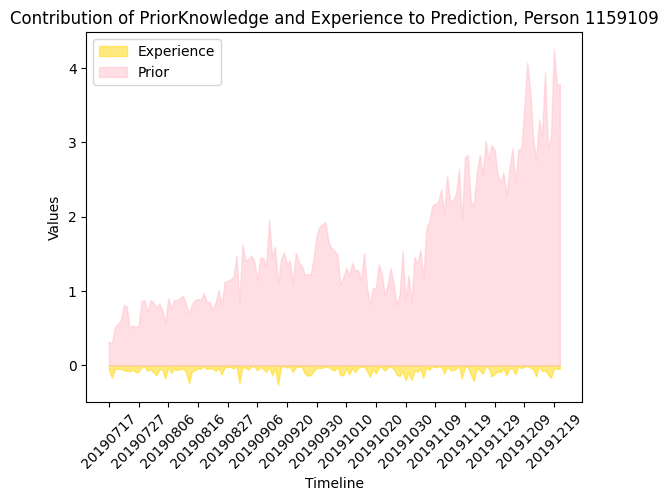

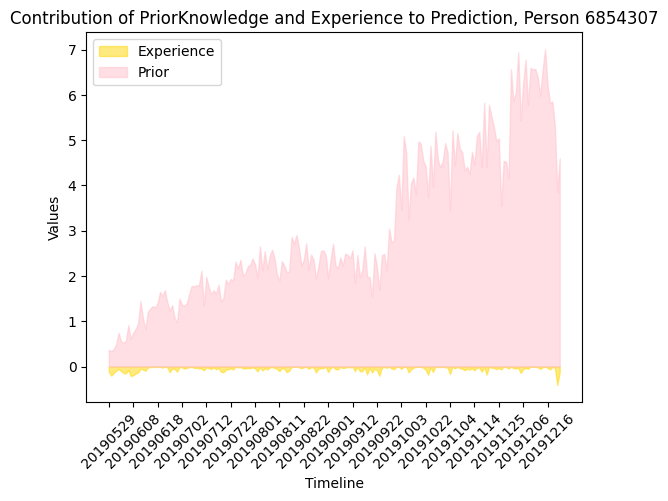

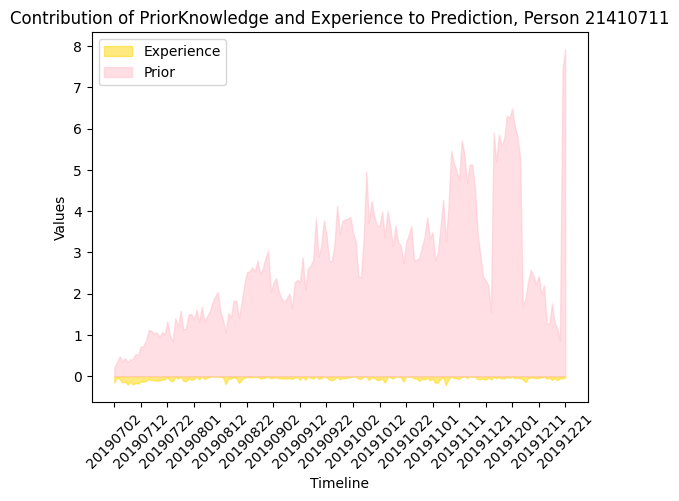

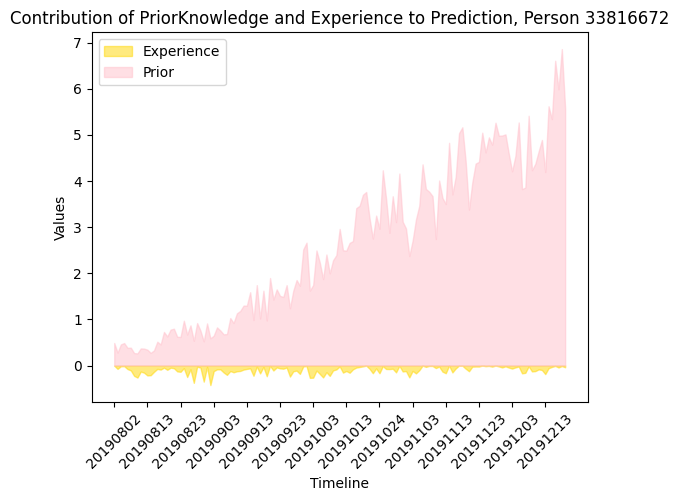

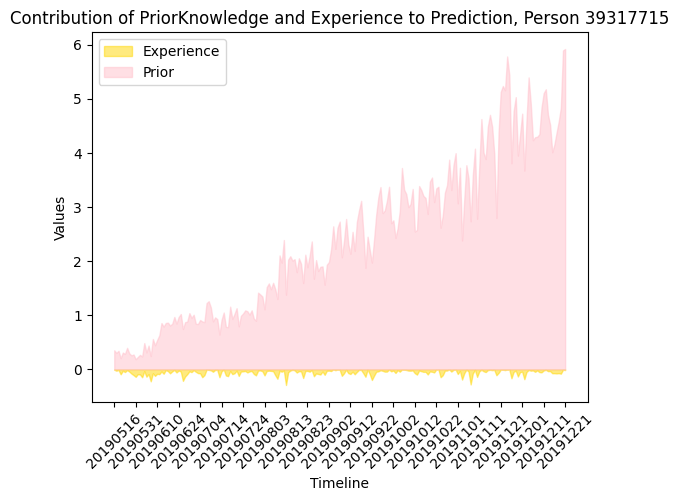

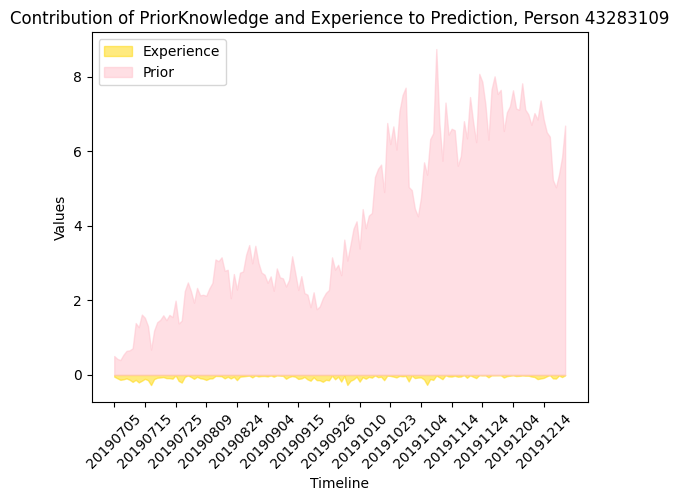

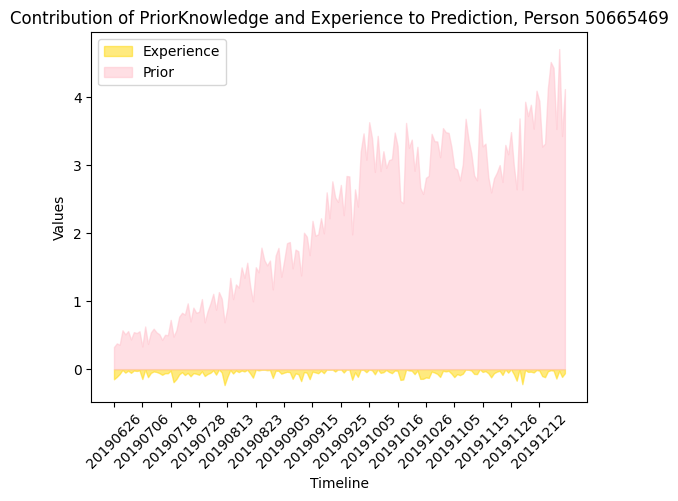

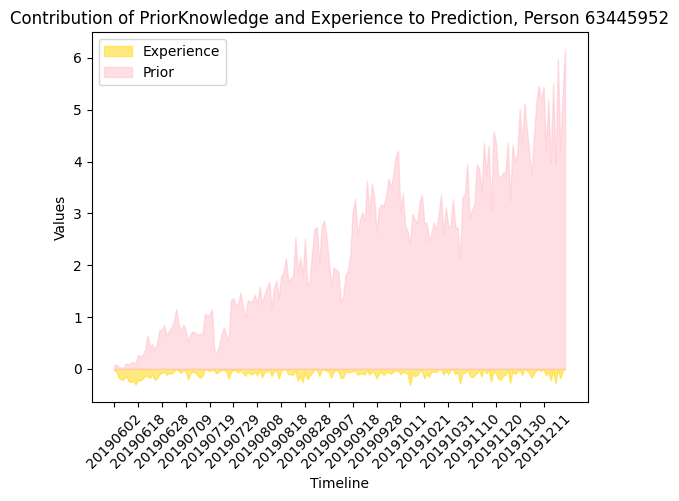

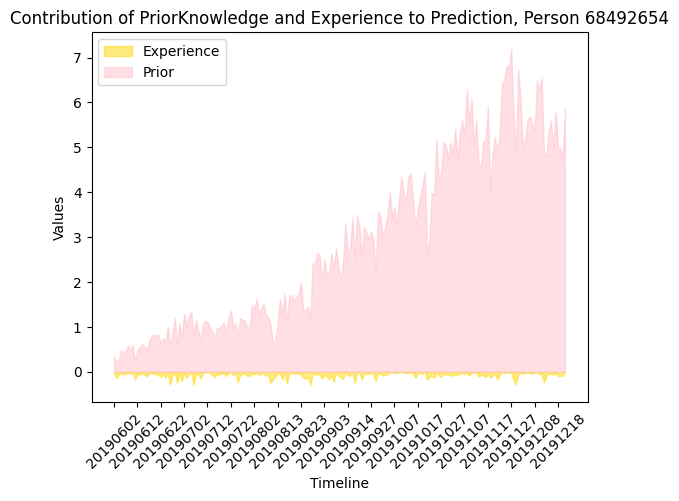

In [37]:
for who, interpDf in interp_res.items():
    x = interpDf.index
    # 创建图形和轴
    fig, ax = plt.subplots()

    y1 = interpDf.pr_contrib
    y2 = interpDf.exp_contrib

    # 绘制堆叠区域
    ax.fill_between(x, -y2, color='gold', alpha=0.5, label='Experience')  # 绿色区域，堆叠在蓝色区域之上
    ax.fill_between(x, y1, color='pink', alpha=0.5, label='Prior')  # 蓝色区域

    # 设置图例
    ax.legend(loc='upper left')

    # 设置图表标题和坐标轴标签
    ax.set_title(f'Contribution of PriorKnowledge and Experience to Prediction, Person {who}')
    ax.set_xlabel('Timeline')
    ax.set_ylabel('Values')

    # 将横坐标的标签设置为日期datelist
    ax.set_xticks(x[::10])
    labels = [str(d) for d in interpDf.date]
    ax.set_xticklabels(labels[::10], rotation=45)
    
    plt.savefig('./product/person_{who:08d}_interp.png'.format(who=who))
    # 显示图表
    plt.show()

In [11]:
reward_res_path = './product/reward_res.pkl'

with open(reward_res_path, 'rb') as f:
    reward_res = pickle.load(f)

{(68492654, 20190602): -0.28384593,
 (68492654, 20190609): -0.13171855,
 (68492654, 20190616): 0.006619673,
 (68492654, 20190623): 0.008254162,
 (68492654, 20190630): 0.023210479,
 (68492654, 20190707): 0.028283158,
 (68492654, 20190714): -0.14734566,
 (68492654, 20190721): -0.15670641,
 (68492654, 20190729): -0.08061703,
 (68492654, 20190805): -0.088300414,
 (68492654, 20190813): -0.12663573,
 (68492654, 20190820): -0.009282699,
 (68492654, 20190828): -0.020696433,
 (68492654, 20190904): 0.03636103,
 (68492654, 20190912): 0.020003077,
 (68492654, 20190919): -0.004545181,
 (68492654, 20190929): -0.0035703958,
 (68492654, 20191006): 0.03652269,
 (68492654, 20191013): 0.07439515,
 (68492654, 20191020): 0.08032082,
 (68492654, 20191027): 0.05993974,
 (68492654, 20191104): 0.042248767,
 (68492654, 20191111): 0.041919146,
 (68492654, 20191118): 0.029966405,
 (68492654, 20191125): 0.039061256,
 (68492654, 20191203): 0.045523513,
 (68492654, 20191210): 0.030032683,
 (68492654, 20191217): -0.0